In [1]:
# import findspark

# findspark.init()

# import pyspark

# from pyspark.sql import SparkSession

# spark = SparkSession.builder.getOrCreate()

# df = spark.sql("select 'spark' as hello ")

# df.show()

+-----+
|hello|
+-----+
|spark|
+-----+



In [1]:
# Importing Relevant Libraries
import numpy as np
import math
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler, StandardScaler
from pyspark.sql.types import *
from pyspark.sql.functions import col, udf
import numpy as np
import pandas as pd
from pyspark.sql import functions as F
from pyspark.ml.feature import *
from pyspark.sql.types import *
from pyspark.ml.linalg import *
from pyspark.sql.functions import *
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel, LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import PipelineModel
from pyspark.ml.stat import Correlation
import seaborn as sns
import pickle
import os
import matplotlib.pyplot as plt
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from spark_stratifier import StratifiedCrossValidator
import pickle

In [2]:
# File location and type
file_location = "../../lish-moa/train_features.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
features_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

In [3]:
# File location and type
file_location = "../../lish-moa/train_targets_scored.csv"
file_type = "csv"

# CSV options
infer_schema = "true"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
targets_data = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

### Pre-Processing

In [4]:
# Dropping samples with cp_type = 'ctl_vehicle' (placebo group would have no activations in any MoAs) 
features_and_targets = features_data.join(targets_data, features_data.sig_id == targets_data.sig_id, how='inner').drop(targets_data.sig_id)
features_and_targets = features_and_targets.filter("cp_type = 'trt_cp'")

In [5]:
# One hot encoding cp_dose

# Indexing different categories in cp_type and storing in column 'cp_type_index'
string_indexer = StringIndexer(inputCol = 'cp_dose', outputCol = 'cp_dose_index')
features_and_targets = string_indexer.fit(features_and_targets).transform(features_and_targets).drop('cp_dose')

# One hot encoded and stored in cp_type_vector column
encoder = OneHotEncoder(inputCols=['cp_dose_index'],
                        outputCols=['cp_dose'], dropLast = False)

features_and_targets = encoder.fit(features_and_targets).transform(features_and_targets).drop('cp_dose_index')

In [6]:
# Label Encoding cp_time
assembler = VectorAssembler(inputCols = ['cp_time'], outputCol = 'cp_time_vector')
features_and_targets = assembler.transform(features_and_targets).drop('cp_time')

mm_scaler = MinMaxScaler(inputCol = 'cp_time_vector', outputCol = 'cp_time_scaled_vector', min = 0, max = 2)
features_and_targets = mm_scaler.fit(features_and_targets).transform(features_and_targets).drop('cp_time_vector')

firstElement=udf(lambda v:float(v[0]),FloatType())
features_and_targets = features_and_targets.withColumn('cp_time', firstElement(features_and_targets['cp_time_scaled_vector'])).drop('cp_time_scaled_vector')

### Stratified train-test split

In [7]:
# Label Set for stratified train-test split
def vector_to_string(a):
  s=''
  for i in a:
    s = s + str(i) + ' '
  s.strip()
  return s
    
  
vector_to_string = udf(vector_to_string)   
spark.udf.register("vector_to_string", vector_to_string)

# Target columns names
target_names = []
for feature in targets_data.columns:
  if feature != 'sig_id':
    target_names.append(feature)
    
temp_df = features_and_targets.withColumn('target_vector', (vector_to_string(array([features_and_targets[col] for col in target_names])))).select(['sig_id', 'target_vector'])
string_indexer = StringIndexer(inputCol = 'target_vector', outputCol = 'target')
string_indexer_model = string_indexer.fit(temp_df)
temp_df = string_indexer_model.transform(temp_df).drop('target_vector')

data = features_and_targets.join(temp_df, features_and_targets.sig_id == temp_df.sig_id, how = 'inner').drop(temp_df.sig_id)

unique_targets = data.select('target').distinct().collect()
fraction = {}
split_ratio = 0.2
for row in unique_targets:
  fraction[row.target] = split_ratio
  
test_data = data.sampleBy('target', fractions=fraction, seed = 0)
data.createOrReplaceTempView('data_table')
test_data.createOrReplaceTempView('test_data_table')
train_data = spark.sql('select * from data_table as t1 where t1.sig_id not in (select t2.sig_id from test_data_table as t2)') 

# Asserting no data leakage
train_data.createOrReplaceTempView('train_data_table')
count = spark.sql('select * from train_data_table as t1 where t1.sig_id in (select t2.sig_id from test_data_table as t2)').count()
assert count == 0

train_data = train_data.drop('target')
test_data = test_data.drop('target')

In [8]:
gene_feature_names = [] # list containing gene expression names
cell_feature_names = [] # list containing cell viability names

for i in range(772):
  gene_feature_names.append('g-' + str(i))

for i in range(100):
  cell_feature_names.append('c-' + str(i))

other_feature_names = ['sig_id', 'cp_type', 'cp_time', 'cp_dose']

target_names = [col for col in train_data.columns if col not in gene_feature_names + cell_feature_names + other_feature_names]

### Feature Engineering

In [ ]:
# Engineering new features: max and min values for gene expression and cell viability data

max_gene_train_df = train_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_train_df = train_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_train_df = train_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_train_df = train_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

max_gene_test_df = test_data.withColumn("gene_max", F.greatest(*gene_feature_names)).select('sig_id', 'gene_max')
min_gene_test_df = test_data.withColumn("gene_min", F.least(*gene_feature_names)).select('sig_id', 'gene_min')
max_cell_test_df = test_data.withColumn("cell_max", F.greatest(*cell_feature_names)).select('sig_id', 'cell_max')
min_cell_test_df = test_data.withColumn("cell_min", F.least(*cell_feature_names)).select('sig_id', 'cell_min')

### Feature Selection

In [16]:
# Correlation among gene expressions and cell viability

cont_features = gene_feature_names + cell_feature_names
cont_features_df = train_data.select(cont_features)

va = VectorAssembler(inputCols = cont_features, outputCol = 'features')
cont_features_df = va.transform(cont_features_df)

corr_df = Correlation.corr(cont_features_df, 'features', 'pearson').collect()[0][0]

corr_mat = corr_df.toArray()


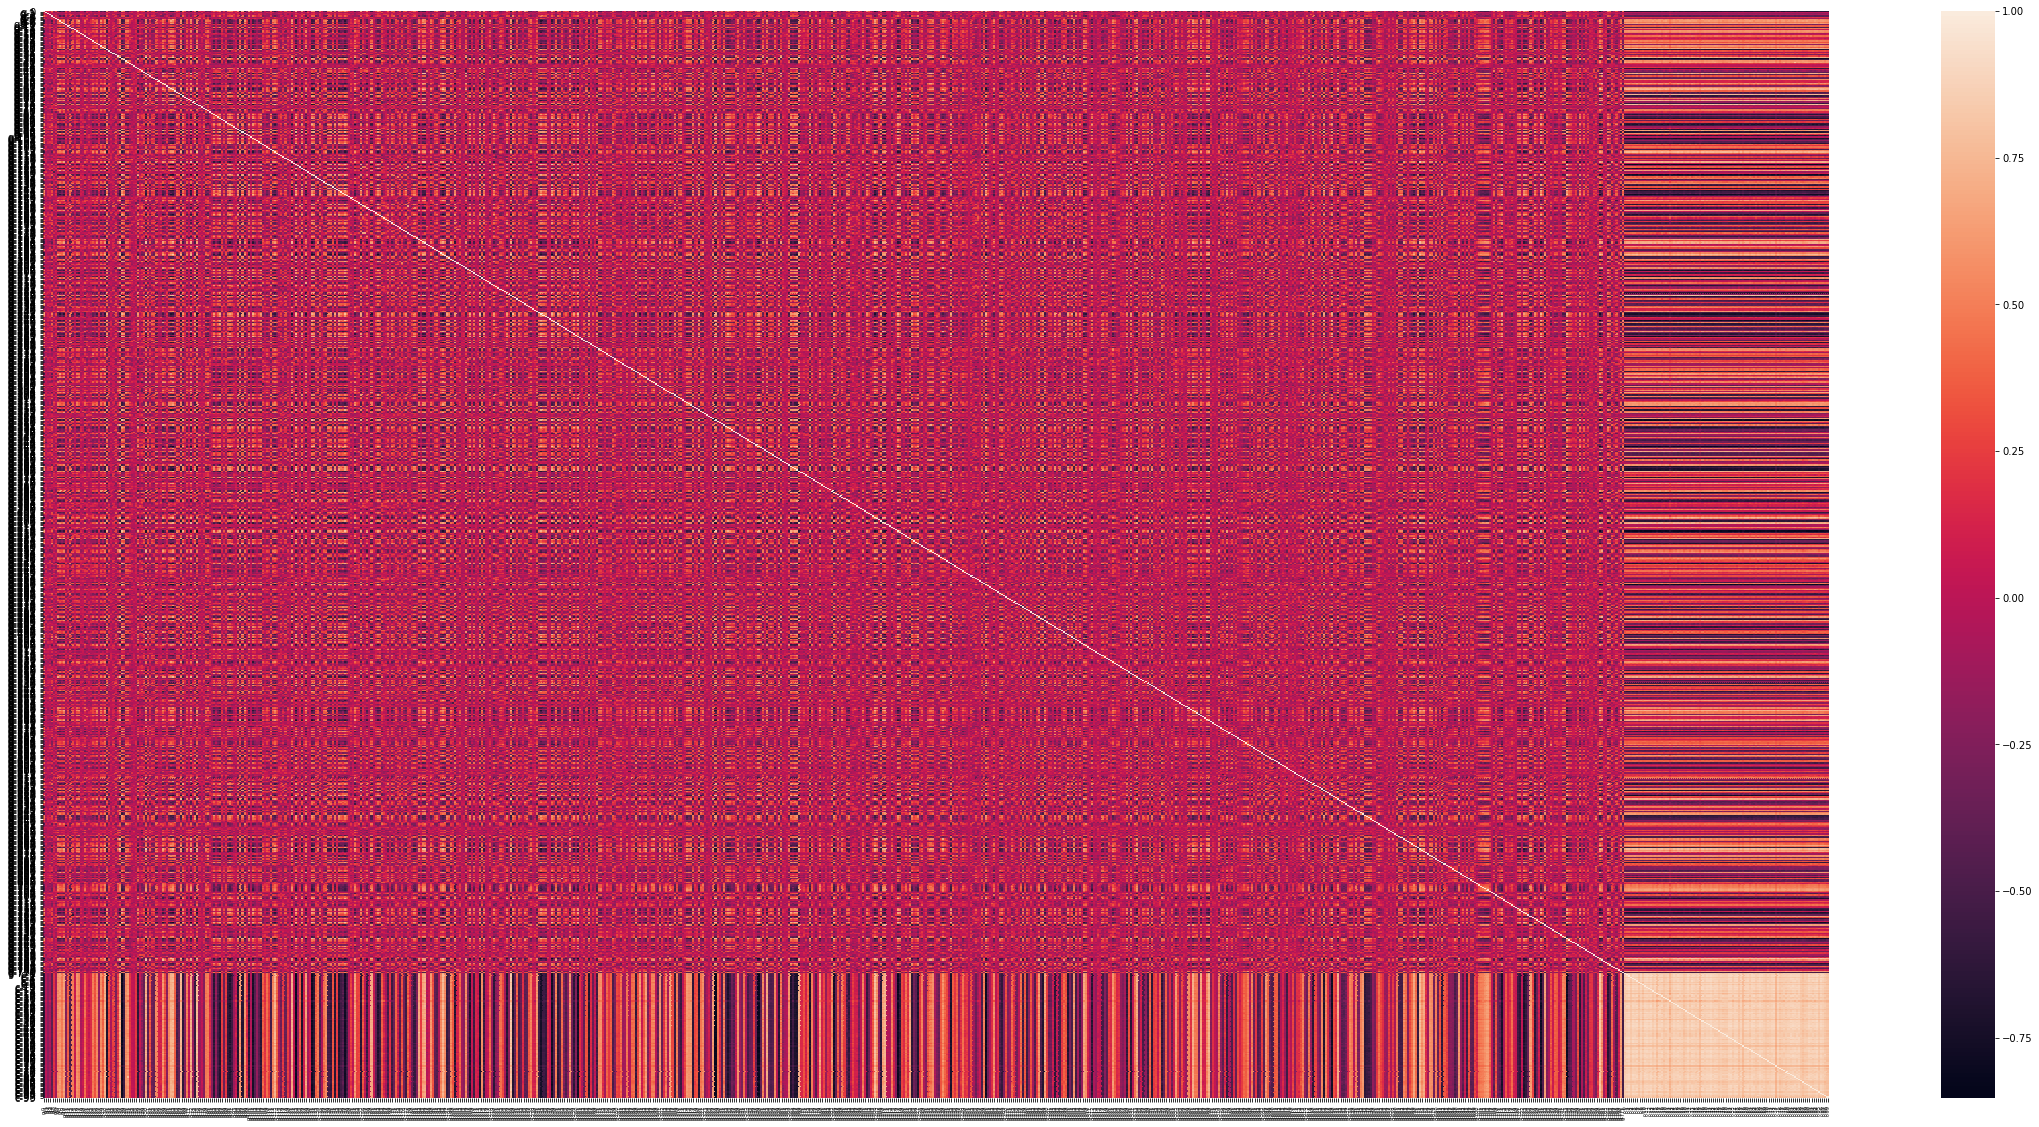

In [17]:
plt.figure(figsize=(40,20))
sns.heatmap(corr_mat, xticklabels = gene_feature_names + cell_feature_names, yticklabels=gene_feature_names + cell_feature_names)
plt.xticks(rotation = 90, fontsize = 5)
plt.show()

In [18]:
# Feature Selection: Removing highly correlated continuos features
threshold = 0.6
columns = np.full((corr_mat.shape[0], ), True, dtype = bool)
for i in range(corr_mat.shape[0]):
  for j in range(i+1, corr_mat.shape[0]):
    if not columns[j]:
      continue
    if corr_mat[i,j] >= threshold or corr_mat[i,j] <= -threshold :
      if columns[j]:
        columns[j] = False

selected_features = [(gene_feature_names + cell_feature_names)[i] for i, j in enumerate(columns) if j==True]

In [19]:
len(selected_features)

530

### Standardizing selected features

Adding engineered  features and then standardizing all continuous features

In [20]:
train_data = train_data.select(other_feature_names + selected_features + target_names).join(max_gene_train_df, on = 'sig_id', how = 'inner').join(min_gene_train_df, on = 'sig_id', how = 'inner').join(max_cell_train_df, on = 'sig_id', how = 'inner').join(min_cell_train_df, on = 'sig_id', how = 'inner')
test_data = test_data.select(other_feature_names + selected_features + target_names).join(max_gene_test_df, on = 'sig_id', how = 'inner').join(min_gene_test_df, on = 'sig_id', how = 'inner').join(max_cell_test_df, on = 'sig_id', how = 'inner').join(min_cell_test_df, on = 'sig_id', how = 'inner')

In [ ]:
selected_features = selected_features + ['gene_max', 'gene_min', 'cell_max', 'cell_min']

In [21]:
va = VectorAssembler(inputCols = selected_features, outputCol = 'feature_vector')

train_data = va.transform(train_data)
test_data = va.transform(test_data)

ss = StandardScaler(withMean=True, inputCol = 'feature_vector', outputCol='features')
ss_model = ss.fit(train_data)

train_data = ss_model.transform(train_data).drop('feature_vector')
test_data = ss_model.transform(test_data).drop('feature_vector')

### Dimensionality Reduction

In [22]:
k = 100
pca = PCA(k = k, inputCol='features', outputCol='pca_features')
pca_model = pca.fit(train_data)

In [23]:
cum_var = np.cumsum(pca_model.explainedVariance.toArray())

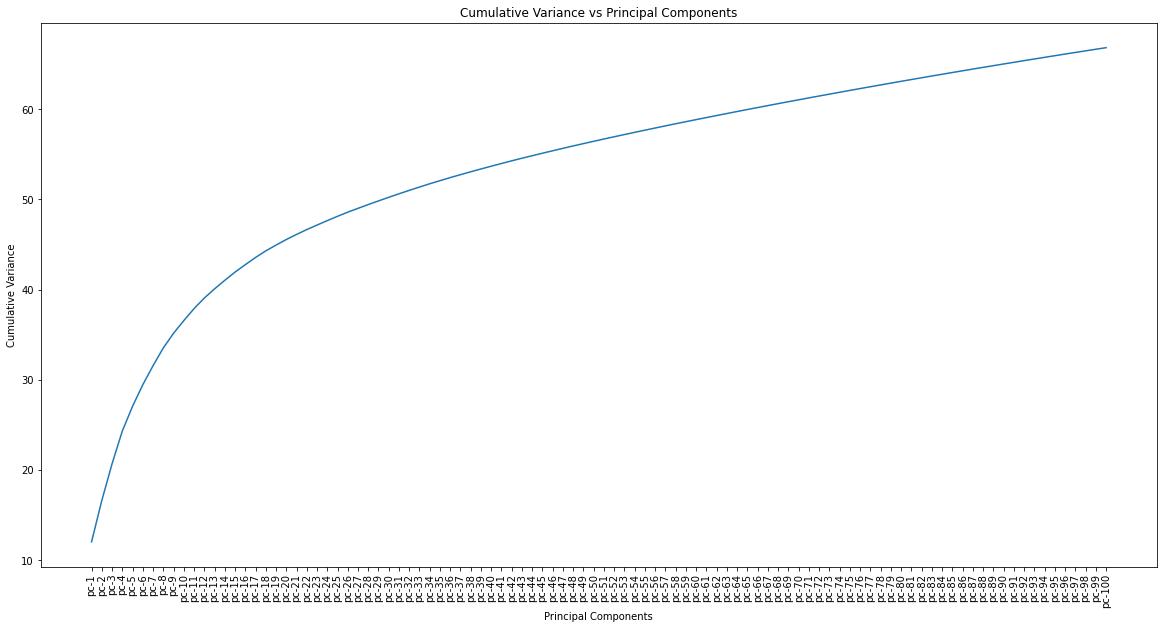

In [24]:
xlabels = ['pc-' + str(i+1) for i in range(k)]
plt.figure(figsize=(20,10))
plt.plot(xlabels, cum_var*100)
plt.xticks(rotation = 90)
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Variance')
plt.title('Cumulative Variance vs Principal Components')
plt.show()

In [25]:
train_data = pca_model.transform(train_data).drop('features')
test_data = pca_model.transform(test_data).drop('features')

In [26]:
train_data = train_data.coalesce(1)

In [27]:
test_data = test_data.coalesce(1)

In [28]:
train_data = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names).cache()
test_data = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + target_names).cache()

In [29]:
train_data.show()

+-------+-------------+--------------------+---------------------------+----------------------+--------------+------------------------------+---------------------------------+------------------------------+--------------------------+-----------------------------+--------------------------+---------------------------+------------------------------+-------------+--------------------------------+-------------+--------------+---------+-------------------------+----------------------------+------------------+----------------------+-------------------------------+-----------------+--------------+----------+--------------+----------+-------------+------------+-----------+-------------+---------+-------------------+-------------------+--------------------+------------------------------------------+----------------------+----------------+--------------------+-----------------------+-------------------+-----------------------------------------+-----------------------------------------+----------

In [30]:
test_data.show()

+-------+-------------+--------------------+---------------------------+----------------------+--------------+------------------------------+---------------------------------+------------------------------+--------------------------+-----------------------------+--------------------------+---------------------------+------------------------------+-------------+--------------------------------+-------------+--------------+---------+-------------------------+----------------------------+------------------+----------------------+-------------------------------+-----------------+--------------+----------+--------------+----------+-------------+------------+-----------+-------------+---------+-------------------+-------------------+--------------------+------------------------------------------+----------------------+----------------+--------------------+-----------------------+-------------------+-----------------------------------------+-----------------------------------------+----------

In [31]:
train_data.rdd.getNumPartitions()

1

In [32]:
test_data.rdd.getNumPartitions()

1

### Stratified Cross Validator

In [33]:
# Reference: https://github.com/interviewstreet/spark-stratifier

import itertools
import numpy as np

from pyspark import since, keyword_only
from pyspark.ml import Estimator, Model
from pyspark.ml.common import _py2java
from pyspark.ml.param import Params, Param, TypeConverters
from pyspark.ml.param.shared import HasSeed
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.ml.util import *
from pyspark.ml.wrapper import JavaParams
from pyspark.sql.functions import rand
from functools import reduce
from multiprocessing.pool import ThreadPool

class StratifiedCrossValidator(CrossValidator):
  def stratify_data(self, dataset):
    """
    Returns an array of dataframes with the same ratio of passes and failures.

    Currently only supports binary classification problems.
    """

    epm = self.getOrDefault(self.estimatorParamMaps)
    numModels = len(epm)
    nFolds = self.getOrDefault(self.numFolds)
    split_ratio = 1.0 / nFolds

    passes = dataset[dataset['label'] == 1]
    fails = dataset[dataset['label'] == 0]

    pass_splits = passes.randomSplit([split_ratio for i in range(nFolds)])
    fail_splits = fails.randomSplit([split_ratio for i in range(nFolds)])
    for i in range(len(pass_splits)):
      one_count_train = pass_splits[i].count()
      zero_count_train = fail_splits[i].count()
      factor = zero_count_train/one_count_train
      if factor > 2:
        fail_splits[i] = fail_splits[i].sample(fraction = 0.5, withReplacement = False,  seed = 0) 
        pass_splits[i] = spark.createDataFrame(pass_splits[i].toPandas().sample(n = fail_splits[i].count(), replace = True,  random_state = 0))
    
    
    stratified_data = [pass_splits[i].unionAll(fail_splits[i]) for i in range(nFolds)]

    return stratified_data

  def _fit(self, dataset):
    est = self.getOrDefault(self.estimator)
    epm = self.getOrDefault(self.estimatorParamMaps)
    numModels = len(epm)
    eva = self.getOrDefault(self.evaluator)
    nFolds = self.getOrDefault(self.numFolds)
    seed = self.getOrDefault(self.seed)
    metrics = [0.0] * numModels
    
    stratified_data = self.stratify_data(dataset)
    
    for i in range(nFolds):
      train_arr = [x for j,x in enumerate(stratified_data) if j != i]
      train = reduce((lambda x, y: x.unionAll(y)), train_arr)
      validation = stratified_data[i]

      models = est.fit(train, epm)

      for j in range(numModels):
        model = models[j]
        metric = eva.evaluate(model.transform(validation, epm[j]))
        metrics[j] += metric/nFolds

    if eva.isLargerBetter():
      bestIndex = np.argmax(metrics)
    else:
      bestIndex = np.argmin(metrics)

    bestModel = est.fit(dataset, epm[bestIndex])
    return self._copyValues(CrossValidatorModel(bestModel, metrics))


### Training - Validation - Testing

In [63]:
losses = []
val_loss = []
best_params = []
total_loss = 0
hamming_losses = []

for i, label in enumerate(target_names):
  
  X_train = train_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label]).withColumnRenamed(label,'label')
  X_test = test_data.select(['cp_time', 'cp_dose', 'pca_features'] + [label]).withColumnRenamed(label, 'label')
    
#   one_count_train = X_train.filter(X_train[label] == 1).count()
#   zero_count_train = X_train.filter(X_train[label] == 0).count()
   
# #   if one_count_train == 0:
# #     untrained_labels.append(label)
# #     n = X_test.count()
# #     prob = np.array([0]*n)
# #     label = np.array(X_test.select(label).toPandas())[:,0]
# #     l = logloss(prob, label)
# #     print('No need to train the model. Will always output 0 for this label')
# #   else:  
#   factor = zero_count_train/one_count_train
#   if factor>=2:
#       zero_samples = X_train.filter(X_train[label]==0).sample(fraction = 0.5, withReplacement = False,  seed = 0) 
#       one_samples = spark.createDataFrame(X_train.filter(X_train[label]==1).toPandas().sample(n = int(X_train.filter(X_train[label]==0).count()/2), replace = True,  random_state = 0))
#       X_train = zero_samples.union(one_samples).orderBy(rand())

  va = VectorAssembler(inputCols = ['cp_time', 'cp_dose', 'pca_features'], outputCol = 'features')
  X_train = va.transform(X_train).coalesce(1)
  X_test = va.transform(X_test)
  gbt = GBTClassifier(labelCol = 'label')  
  evaluator = MulticlassClassificationEvaluator(labelCol='label', metricName='logLoss')
  params = ParamGridBuilder().addGrid(gbt.maxIter, [20,30]).addGrid(gbt.maxDepth, [5,10]).build()
  print('Cross Validating')
  scv = StratifiedCrossValidator(estimator=gbt, estimatorParamMaps=params, evaluator=evaluator, numFolds=3, seed=42, parallelism=2)
  scv_model = scv.fit(X_train)
  print('Cross Validaton done')
  best_model = scv_model.bestModel
  val_loss.append(scv_model.avgMetrics)
  param_dict = {'maxIter': best_model.getMaxIter(), 'maxDepth': best_model.getMaxDepth()}
  best_params.append(param_dict)
  pred_df = scv_model.transform(X_test)
  l= evaluator.evaluate(pred_df)
    
  losses.append(l)
  print(f'Label Loss for {i}: {label} = {l}')
  total_loss+=l
  hamming_loss = total_loss/(i+1)  
  hamming_losses.append(hamming_loss)  
  print(f'Hamming Loss after {i}: {label} = {hamming_loss}')
  d = {'test_losses': losses, 'val_losses': val_loss, 'best_params':best_params, 'hamming_losses': hamming_losses}
  f = open('data2.pkl', 'wb')
  pickle.dump(d, f)
  f.close()  
  print('################################')
  X_train.unpersist()
  X_test.unpersist()
  pred_df.unpersist()  
  


Cross Validating
Cross Validaton done
Label Loss for 0: 5-alpha_reductase_inhibitor = 0.03457635926845083
Hamming Loss after 0: 5-alpha_reductase_inhibitor = 0.03457635926845083
################################
Cross Validating
Cross Validaton done
Label Loss for 1: 11-beta-hsd1_inhibitor = 0.035363116591408644
Hamming Loss after 1: 11-beta-hsd1_inhibitor = 0.03496973792992974
################################
Cross Validating
Cross Validaton done
Label Loss for 2: acat_inhibitor = 0.03419740021890976
Hamming Loss after 2: acat_inhibitor = 0.03471229202625641
################################
Cross Validating
Cross Validaton done
Label Loss for 3: acetylcholine_receptor_agonist = 0.05536741676066395
Hamming Loss after 3: acetylcholine_receptor_agonist = 0.039876073209858295
################################
Cross Validating
Cross Validaton done
Label Loss for 4: acetylcholine_receptor_antagonist = 0.08459099362984276
Hamming Loss after 4: acetylcholine_receptor_antagonist = 0.048819057293

Cross Validating
Cross Validaton done
Label Loss for 41: bacterial_50s_ribosomal_subunit_inhibitor = 0.03915629406373069
Hamming Loss after 41: bacterial_50s_ribosomal_subunit_inhibitor = 0.04057842507766882
################################
Cross Validating
Cross Validaton done
Label Loss for 42: bacterial_antifolate = 0.03475090090605144
Hamming Loss after 42: bacterial_antifolate = 0.040442901259724225
################################
Cross Validating
Cross Validaton done
Label Loss for 43: bacterial_cell_wall_synthesis_inhibitor = 0.06151448208116317
Hamming Loss after 43: bacterial_cell_wall_synthesis_inhibitor = 0.04092180082384784
################################
Cross Validating
Cross Validaton done
Label Loss for 44: bacterial_dna_gyrase_inhibitor = 0.04441055251864556
Hamming Loss after 44: bacterial_dna_gyrase_inhibitor = 0.040999328639287784
################################
Cross Validating
Cross Validaton done
Label Loss for 45: bacterial_dna_inhibitor = 0.05026688690326181

Cross Validating
Cross Validaton done
Label Loss for 81: elastase_inhibitor = 0.03345727804217823
Hamming Loss after 81: elastase_inhibitor = 0.04234449982694935
################################
Cross Validating
Cross Validaton done
Label Loss for 82: erbb2_inhibitor = 0.03308835433851901
Hamming Loss after 82: erbb2_inhibitor = 0.04223298000178754
################################
Cross Validating
Cross Validaton done
Label Loss for 83: estrogen_receptor_agonist = 0.05180764779256728
Hamming Loss after 83: estrogen_receptor_agonist = 0.04234696414215396
################################
Cross Validating
Cross Validaton done
Label Loss for 84: estrogen_receptor_antagonist = 0.03809821041005705
Hamming Loss after 84: estrogen_receptor_antagonist = 0.0422969788041293
################################
Cross Validating
Cross Validaton done
Label Loss for 85: faah_inhibitor = 0.036072481854029045
Hamming Loss after 85: faah_inhibitor = 0.042224600932616506
################################
Cros

Cross Validating
Cross Validaton done
Label Loss for 122: leukotriene_receptor_antagonist = 0.04217322765731301
Hamming Loss after 122: leukotriene_receptor_antagonist = 0.04194167543550226
################################
Cross Validating
Cross Validaton done
Label Loss for 123: lipase_inhibitor = 0.0340416062812455
Hamming Loss after 123: lipase_inhibitor = 0.041877965200387286
################################
Cross Validating
Cross Validaton done
Label Loss for 124: lipoxygenase_inhibitor = 0.04046196287867704
Hamming Loss after 124: lipoxygenase_inhibitor = 0.041866637181813604
################################
Cross Validating
Cross Validaton done
Label Loss for 125: lxr_agonist = 0.03310503426972107
Hamming Loss after 125: lxr_agonist = 0.04179710065076525
################################
Cross Validating
Cross Validaton done
Label Loss for 126: mdm_inhibitor = 0.03551933396361892
Hamming Loss after 126: mdm_inhibitor = 0.04174766941700819
################################
Cross Va

Cross Validating
Cross Validaton done
Label Loss for 162: prostanoid_receptor_antagonist = 0.04919956152859931
Hamming Loss after 162: prostanoid_receptor_antagonist = 0.04136073644628238
################################
Cross Validating
Cross Validaton done
Label Loss for 163: proteasome_inhibitor = 0.03563152257495926
Hamming Loss after 163: proteasome_inhibitor = 0.041325802215359676
################################
Cross Validating
Cross Validaton done
Label Loss for 164: protein_kinase_inhibitor = 0.03696177817429894
Hamming Loss after 164: protein_kinase_inhibitor = 0.041299353584807796
################################
Cross Validating
Cross Validaton done
Label Loss for 165: protein_phosphatase_inhibitor = 0.03312474574938029
Hamming Loss after 165: protein_phosphatase_inhibitor = 0.04125010895929317
################################
Cross Validating
Cross Validaton done
Label Loss for 166: protein_synthesis_inhibitor = 0.04354745294880555
Hamming Loss after 166: protein_synthesi

Cross Validating
Cross Validaton done
Label Loss for 202: vegfr_inhibitor = 0.055391688270851155
Hamming Loss after 202: vegfr_inhibitor = 0.04110460317080044
################################
Cross Validating
Cross Validaton done
Label Loss for 203: vitamin_b = 0.03649325747471201
Hamming Loss after 203: vitamin_b = 0.0410819985350353
################################
Cross Validating
Cross Validaton done
Label Loss for 204: vitamin_d_receptor_agonist = 0.03660656122724859
Hamming Loss after 204: vitamin_d_receptor_agonist = 0.0410601671335339
################################
Cross Validating
Cross Validaton done
Label Loss for 205: wnt_inhibitor = 0.03530576536630303
Hamming Loss after 205: wnt_inhibitor = 0.041032233144372585
################################


In [64]:
with open('data2.pkl', 'rb') as f:
    data = pickle.load(f)

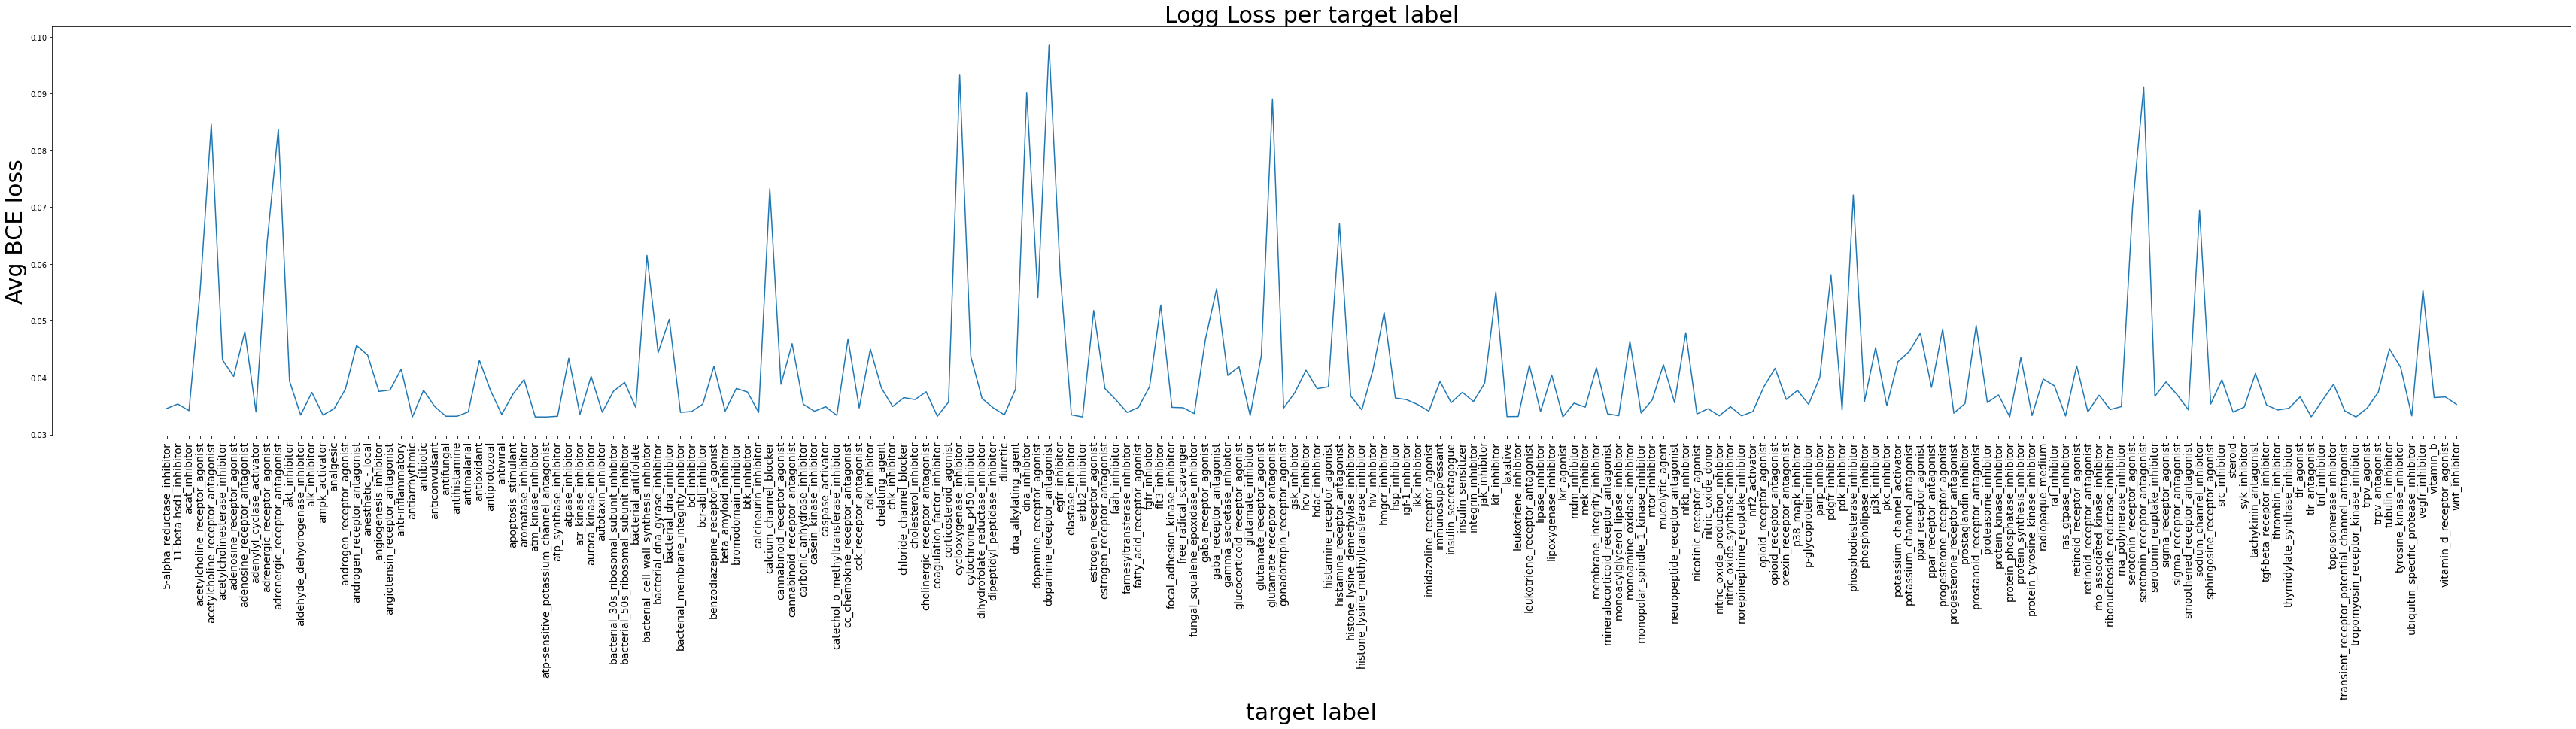

In [66]:
plt.figure(figsize = (60,10))
plt.plot(target_names, data['test_losses'])
plt.title('Logg Loss per target label', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Avg BCE loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.show()

In [68]:
data1 = data

In [70]:
data1['train_data'] = train_data.toPandas()
data1['test_data'] = test_data.toPandas()
data1['hamming_losses'] = hamming_losses
data1['variance'] = pca_model.explainedVariance.toArray()
data1['cumulative_variance'] = cum_var
data1['correlation_matrix'] = corr_mat
data1['selected_features'] = selected_features

In [71]:
with open('data.pkl', 'wb') as f:
    pickle.dump(data1, f)


### Comparison of tuned GBT with untunted GBT

In [10]:
with open('data.pkl', 'rb') as f:
    data_tuned = pickle.load(f)

In [11]:
with open('../GBT/data.pkl', 'rb') as f:
    data_untuned = pickle.load(f)

In [12]:
data_tuned.keys()

dict_keys(['test_losses', 'val_losses', 'best_params', 'train_data', 'test_data', 'hamming_losses', 'variance', 'cumulative_variance', 'correlation_matrix', 'selected_features'])

In [13]:
data_untuned.keys()

dict_keys(['losses', 'untrained_labels', 'train_data', 'test_data', 'hamming_loss', 'variance', 'cumulative_variance', 'correlation_matrix', 'selected_features'])

In [14]:
test_loss_tuned = data_tuned['test_losses']
test_loss_untuned = data_untuned['losses']

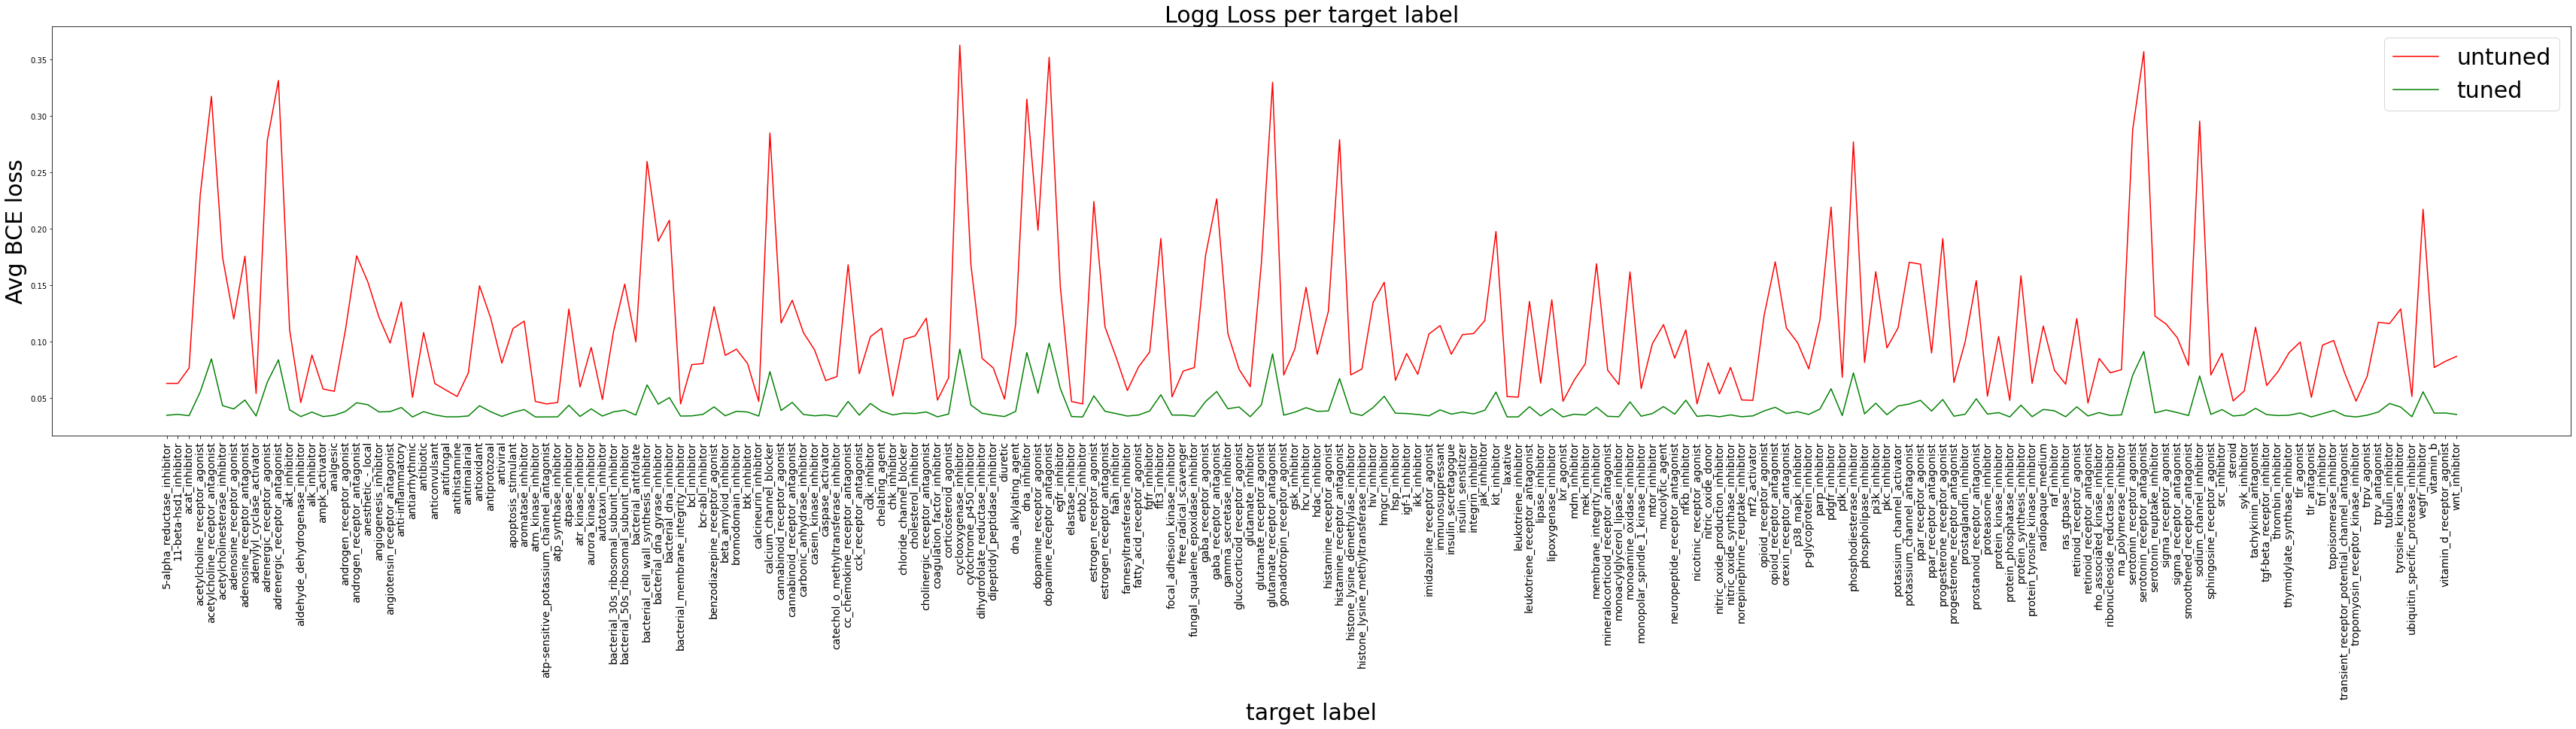

In [20]:
plt.figure(figsize = (60,10))
plt.plot(target_names, test_loss_untuned, color = 'red', label = 'untuned')
plt.plot(target_names, test_loss_tuned, color = 'green', label = 'tuned')
plt.title('Logg Loss per target label', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Avg BCE loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.legend(fontsize = 30)
plt.show()

In [16]:
hamming_loss_tuned = data_tuned['hamming_losses']
hamming_loss_untuned = data_untuned['hamming_loss']

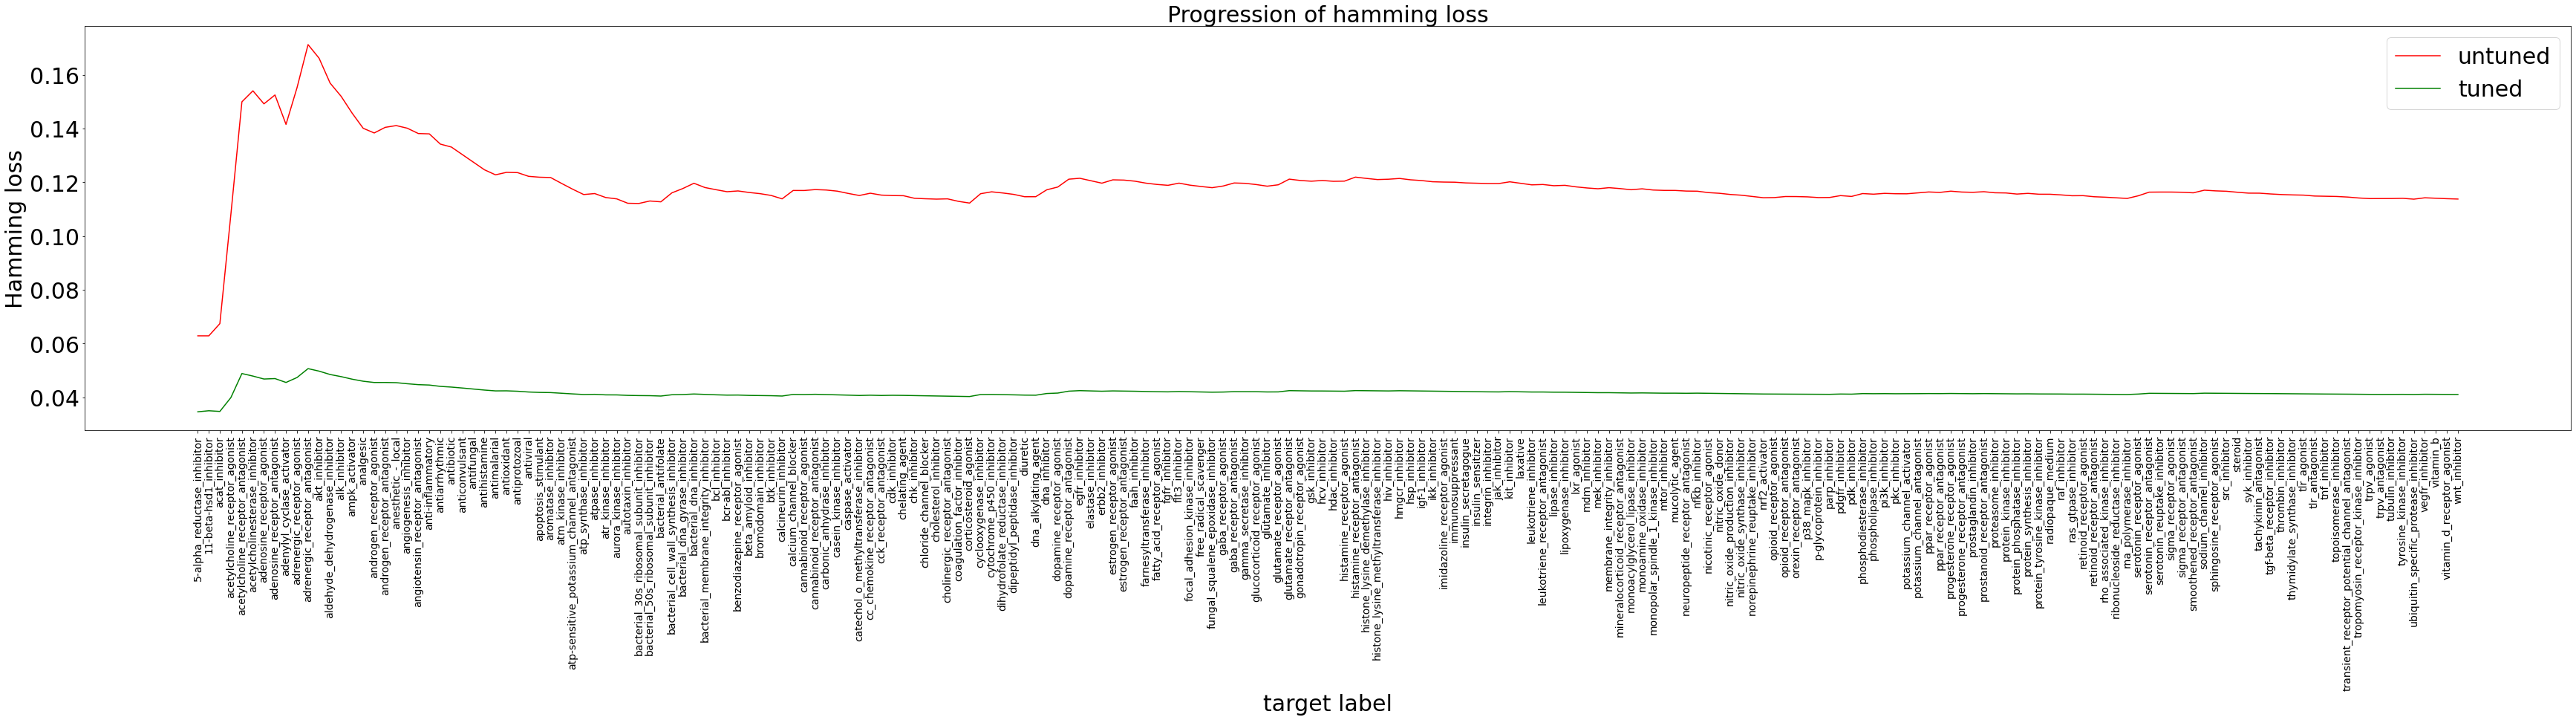

In [19]:
plt.figure(figsize = (60,10))
plt.plot(target_names, hamming_loss_untuned, color = 'red', label = 'untuned')
plt.plot(target_names, hamming_loss_tuned, color = 'green', label = 'tuned')
plt.title('Progression of hamming loss', fontsize = 30)
plt.xlabel('target label', fontsize=30)
plt.ylabel('Hamming loss', fontsize = 30)
plt.xticks(rotation = 90, fontsize = 14)
plt.yticks(fontsize = 30)
plt.legend(fontsize = 30)
plt.show()